In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import numpy as np

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def show(img):
    '''
        Helper Function to show images, must convert from GPU tensor to
        CPU ndarray first through img.cpu().detach().numpy()
    '''
    plt.figure()
    plt.imshow(img, cmap = 'gray')

In [0]:
USE_CUDA = True
DEVICE   = ('cuda' if USE_CUDA else 'cpu')

In [0]:
SEED = 123
BATCH_SIZE = 128

LATENT_SIZE = 4

In [0]:
torch.manual_seed(SEED)

datapath = "/gdrive/My Drive/workspace/MMD_VAE"
localpath = '/content'

In [0]:
import os
os.chdir(datapath)

# MMD Objective using Gaussian Kernel

In [0]:
def gaussian_kernel(a, b):
    dim1_1, dim1_2 = a.shape[0], b.shape[0]
    depth = a.shape[1]
    a = a.view(dim1_1, 1, depth)
    b = b.view(1, dim1_2, depth)
    a_core = a.expand(dim1_1, dim1_2, depth)
    b_core = b.expand(dim1_1, dim1_2, depth)
    numerator = (a_core - b_core).pow(2).mean(2)/depth
    return torch.exp(-numerator)

def MMD(a, b):
    return gaussian_kernel(a, a).mean() + gaussian_kernel(b, b).mean() - 2*gaussian_kernel(a, b).mean()

In [0]:
def loss_function(pred, true, latent):
    return (pred-true).pow(2).mean(), MMD(torch.randn(200, LATENT_SIZE, requires_grad = False).to(DEVICE), latent)

# Loading MNIST data, can substitute here for other data.

In [11]:
train = datasets.MNIST('data', train = True , transform = transforms.ToTensor(), download = True)
test  = datasets.MNIST('data', train = False, transform = transforms.ToTensor(), download = True)

0it [00:00, ?it/s]

9920512it [00:01, 8601583.31it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 127490.13it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2103192.32it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 48930.44it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
# Converting from integer to float, also to DEVICE (CPU or GPU)

train = train.data.float().to(DEVICE)/256
test  = test.data.float().to(DEVICE)/256

In [0]:
train_loader = DataLoader(
    dataset = train,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test,
    batch_size = BATCH_SIZE,
    shuffle = True
)

# VAE architecture


In [0]:
class Reshape(nn.Module):
    '''
        Used in a nn.Sequential pipeline to reshape on the fly.
    '''
    def __init__(self, *target_shape):
        super().__init__()
        self.target_shape = target_shape
    
    def forward(self, x):
        return x.view(*self.target_shape)

In [0]:
class MMD_VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 5, padding = 2), #1*28*28 -> 5*28*28
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 5, out_channels = 5, kernel_size = 5), #5*28*28 -> 5*24*24
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 5, out_channels = 5, kernel_size = 5), #5*24*24 -> 5*20*20
            nn.LeakyReLU(),
            Reshape([-1,5*20*20]),
            nn.Linear(in_features = 5*20*20, out_features = 5*12),
            nn.LeakyReLU(),
            nn.Linear(in_features = 5*12, out_features = LATENT_SIZE)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features = LATENT_SIZE, out_features = 5*12),
            nn.ReLU(),
            nn.Linear(in_features = 5*12, out_features = 24*24),
            nn.ReLU(),
            Reshape([-1,1,24,24]),
            nn.ConvTranspose2d(in_channels = 1, out_channels = 5, kernel_size = 3), #1*24*24 -> 5*26*26
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 5, out_channels = 10, kernel_size = 5), #5*26*26 -> 10*30*30
            nn.ReLU(),
            nn.Conv2d(in_channels = 10, out_channels = 1, kernel_size = 3), #10*30*30 -> 1*28*28
            nn.Sigmoid()
        )
    
    def forward(self, X):
        if self.training:
            latent = self.encoder(X)
            return self.decoder(latent), latent
        else:
            return self.decoder( self.encoder(X) )

# Training loop


In [0]:
def train(net, learning_rate, epochs, train_loader, test_loader, optimizer = 'Adam'):
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr = learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, 
                              momentum = .95, nesterov = True)
    
    for epoch in range(epochs):
        training_loss = 0
        training_reconstruction_error = 0
        training_mmd = 0

        net.train()
        for batchnum, X in enumerate(train_loader):
            optimizer.zero_grad()

            X = X.reshape(-1, 1, 28, 28)
            reconstruction, mu = net(X)
            reconstruction_error, mmd = loss_function(reconstruction, X, mu)
            loss = reconstruction_error + mmd
            loss.backward()
            
            optimizer.step()

            training_reconstruction_error += reconstruction_error
            training_mmd  += mmd
            training_loss += loss

        training_reconstruction_error /= (batchnum+1)
        training_mmd  /= (batchnum+1)
        training_loss /= (batchnum+1)
        print('Training loss for epoch %i is %.8f, Reconstruction is %.8f, mmd is %.8f'%(epoch, training_loss, training_reconstruction_error, training_mmd) )
        
        #Testing loop

        testing_reconstruction_error = 0
        testing_mmd = 0

        with torch.no_grad():
            for batchnum, X in enumerate(test_loader):
                X = X.reshape(-1, 1, 28, 28)
                reconstruction, mu = net(X)
                reconstruction_error, mmd = loss_function(reconstruction, X, mu)

                testing_reconstruction_error += reconstruction_error
                testing_mmd += mmd
            
            testing_reconstruction_error /= (batchnum+1)
            testing_mmd /= (batchnum+1)
            print('Testing loss for epoch %i is %.8f, Reconstruction is %.8f, mmd is %.8f'%(epoch, testing_reconstruction_error + testing_mmd, testing_reconstruction_error, testing_mmd) )
        

# Training net, extracting samples

In [0]:
net = MMD_VAE().to('cuda')

In [23]:
train(net, learning_rate = .0001, epochs = 30,
      train_loader = train_loader, test_loader = test_loader)

Training loss for epoch 0 is 0.19385393, Reconstruction is 0.13172628, mmd is 0.06212759
Testing loss for epoch 0 is 0.14777656, Reconstruction is 0.08665911, mmd is 0.06111745
Training loss for epoch 1 is 0.10895792, Reconstruction is 0.07370204, mmd is 0.03525600
Testing loss for epoch 1 is 0.07598224, Reconstruction is 0.06375752, mmd is 0.01222472
Training loss for epoch 2 is 0.06605402, Reconstruction is 0.05689355, mmd is 0.00916045
Testing loss for epoch 2 is 0.05972357, Reconstruction is 0.05239603, mmd is 0.00732754
Training loss for epoch 3 is 0.05559016, Reconstruction is 0.04971901, mmd is 0.00587115
Testing loss for epoch 3 is 0.05237744, Reconstruction is 0.04650369, mmd is 0.00587375
Training loss for epoch 4 is 0.04928217, Reconstruction is 0.04373658, mmd is 0.00554562
Testing loss for epoch 4 is 0.04639298, Reconstruction is 0.04144757, mmd is 0.00494540
Training loss for epoch 5 is 0.04636785, Reconstruction is 0.04090912, mmd is 0.00545874
Testing loss for epoch 5 i

## Extracting samples

One way to visualize the latent space is below. We can only visualize up to 2 dimensions, but often have a higher dimensional latent space. 

First, we sample from a ```LATENT_SIZE-2``` dimensional Isotropic Gaussian once, and duplicate it so that we have 64 of them. We now have 64 base vectors. We then create a grid by permuting two axes together. Each axis spans from [-1,1] and has 8 evenly spaced points, so we have a grand total of 64 2-dimensional points. We then stack the 64 2-dimensional points with the 64 base vectors to get a 2d grid of points in possibly higher dimensional latent space.

```sample_from_latent()``` has the procedure to use the function ```get_sampling_grid()``` if a custom grid is wanted.

In [0]:
from itertools import product

#Manages device/graph status/type handling
def from_latent(net, vec):
    with torch.no_grad():
        net.eval()
        return net.decoder( torch.tensor(vec).to(DEVICE).float() ).cpu().detach().numpy().reshape(28,28)

def get_sampling_grid(net, grid):
    base = torch.randn(LATENT_SIZE-2)
    image = torch.tensor([])
    for vec in grid:
        image = torch.cat([image, torch.from_numpy(from_latent(net, np.hstack([vec, base]) ) ) ] )
    return image.view(64,1,28,28)

def sample_from_latent(net, save = True, location = 'grid.png'):
    grid = list(product(np.linspace(-1,1,8), np.linspace(-1,1,8) ) )
    results = get_sampling_grid(net, grid)
    if save:
        save_image(results, location)
    return results

from torchvision.utils import make_grid
def show_image_grid(results):
    img = make_grid(results, nrow = 8)
    plt.imshow(img.permute(1,2,0) )

This saves an 8x8 grid of samples using the method in the text box above. The default location is the current working directory + grid.png

It also outputs it in the display box.

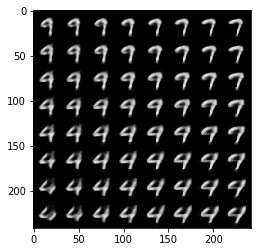

In [84]:
sampled_images = sample_from_latent(net, save = False)

show_image_grid(sampled_images)